# INFO-4604 Final Project 

* Created by Garrett Glissmann on November 17, 2017

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.svm import SVR
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.neural_network import MLPRegressor

dfMovies = pd.read_csv('tmdb_5000_movies_out_final.csv', sep=',', header=0, encoding='latin1')
dfMovies.head()

,budget,homepage,id,original_title,overview,popularity,release_date,revenue,runtime,status,...,Keyword_gang,Keyword_psychopath,Keyword_neighbor,Keyword_mother daughter relationship,Keyword_drug dealer,Keyword_faith,Keyword_mutant,Keyword_hero,Keyword_rivalry,Keyword_california
0,237000000,http://www.avatarmovie.com/,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,12/10/09,2787965087,162.0,Released,...,0,0,0,0,0,0,0,0,0,0
1,300000000,http://disney.go.com/disneypictures/pirates/,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,5/19/07,961000000,169.0,Released,...,0,0,0,0,0,0,0,0,0,0
2,245000000,http://www.sonypictures.com/movies/spectre/,206647,Spectre,A cryptic message from BondÛªs past sends him...,107.376788,10/26/15,880674609,148.0,Released,...,0,0,0,0,0,0,0,0,0,0
3,250000000,http://www.thedarkknightrises.com/,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,7/16/12,1084939099,165.0,Released,...,0,0,0,0,0,0,0,1,0,0
4,260000000,http://movies.disney.com/john-carter,49529,John Carter,"John Carter is a war-weary, former military ca...",43.926995,3/7/12,284139100,132.0,Released,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Remove these columns for now
dfMoviesSelect = dfMovies.drop([
    'homepage', 'id', 'original_title', 'overview', 'release_date', 'title', 'status', 'tagline'
], axis=1)
# Fill NA's with 0
dfMoviesSelect.fillna(0, inplace=True)
# Make popularity an integer
dfMoviesSelect["popularity"] = dfMoviesSelect["popularity"].astype(int)

df_revenue_X = dfMoviesSelect.loc[:, dfMoviesSelect.columns != 'revenue']
df_revenue_Y = dfMoviesSelect.loc[:, dfMoviesSelect.columns == 'revenue']

df_vote_X = dfMoviesSelect.loc[:, dfMoviesSelect.columns != 'vote_average']
df_vote_Y = dfMoviesSelect.loc[:, dfMoviesSelect.columns == 'vote_average']

dfMoviesSelect.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,genres_action,genres_adventure,genres_fantasy,genres_science_fiction,...,Keyword_gang,Keyword_psychopath,Keyword_neighbor,Keyword_mother daughter relationship,Keyword_drug dealer,Keyword_faith,Keyword_mutant,Keyword_hero,Keyword_rivalry,Keyword_california
0,237000000,150,2787965087,162.0,7.2,11800,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,300000000,139,961000000,169.0,6.9,4500,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,245000000,107,880674609,148.0,6.3,4466,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,250000000,112,1084939099,165.0,7.6,9106,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,260000000,43,284139100,132.0,6.1,2124,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [82]:
class RegressionSteps:
    def __init__(self, all_x, all_y, test_size=[0.2], do_std=False, percentiles=[1,5,10], C_param=[0.1, 1, 10], kernel_param=['rbf'], layer_param=[(200)]):
        self.all_x = all_x
        self.all_y = all_y
        self.random_state = 123
        self.test_size = test_size
        self.do_std = do_std
        self.percentiles = percentiles
        self.C_param = C_param
        self.kernel_param = kernel_param
        self.layer_param = layer_param
        
        self.Y_train = False
        self.Y_test = False
        
        self.best_r2 = 0
        self.best_model = False
        self.best_y_predict = False
        
        self.regressors = ['Linear', 'SVR', 'MLP']
        self.y_plot_r2 = False
    
    def reset_plot_data(self):
        lists = [[] for i in range(len(self.regressors))]
        self.y_plot_r2 = dict(zip(self.regressors, lists))
        
    def start(self):
        for ts in self.test_size:
            print("Starting data split: {}/{}".format(int(100*(1 - ts)), int(ts * 100)))
            self.start_set(ts, self.all_x, self.all_y)
            
        if (self.best_model != False):
            print("\n******** Best ********\n")
            print("Best model\n", self.best_model)
            print("Training R2 score: ", self.best_r2)
            # The mean squared error
            print("Test mean squared error: %.2f" % mean_squared_error(self.Y_test, self.best_y_predict))
            # Explained variance score: 1 is perfect prediction
            print("Test R2 score: %.2f" % r2_score(self.Y_test, self.best_y_predict))
            # Different?
            print("Test explained variance score: %.2f" % explained_variance_score(self.Y_test, self.best_y_predict))
    
    def start_set(self, test_size, x_train_all, x_test_all):
        X_train, X_test, self.Y_train, self.Y_test = train_test_split(
            x_train_all, 
            x_test_all, 
            test_size=test_size, 
            random_state=self.random_state
        )
        
        if (self.do_std):
            X_train, X_test = self.get_standardization(X_train, X_test)
            
        self.do_tests(X_train, X_test)
        
    def get_standardization(self, X_train, X_test):
        # Standardization
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train_std = min_max_scaler.fit_transform(X_train, self.Y_train)
        X_test_std = min_max_scaler.transform(X_test)
        return X_train_std, X_test_std
        
    # Feature selection (percentile)
    def get_selection(self, per, x_train, x_test):
        selection = SelectPercentile(percentile=per, score_func=chi2)
        x_train_sel = selection.fit_transform(x_train, self.Y_train)
        x_test_sel = selection.transform(x_test)
        return x_train_sel, x_test_sel
    
    def fit_and_predict (self, model, x_train, x_test, key, params = {}):
        result = False
        if (len(params) > 0):
            # Performs 5-fold cross-validation with the above classifier and parameter options
            result = GridSearchCV(model, params, cv=5)
        else:
            result = model
        # Train the model using the training sets
        result.fit(x_train, self.Y_train)
        # Make predictions using the training set
        y_pred_train = result.predict(x_train)
        # Make predictions using the testing set
        y_pred_test = result.predict(x_test)
        # Validation R2 score
        r2 = r2_score(self.Y_train, y_pred_train)
        # R2: 1 is perfect prediction
        print("\tR2 score: %.2f" % r2)
        
        self.y_plot_r2[key].append(r2)
        
        if (r2 > self.best_r2):
            self.best_r2 = r2
            self.best_model = result
            self.best_y_predict = y_pred_test
    
    def do_tests(self, x_train, x_test):
        self.reset_plot_data()
        for p in self.percentiles:
            print("\nPercentile: {}".format(p))
            x_train_sel, x_test_sel = self.get_selection(p, x_train, x_test)
            self.test_selection(x_train_sel, x_test_sel)

    def test_selection(self, X_train, X_test):
        # Simple linear regression model
        print("\tLinear Regression:")
        regr = linear_model.LinearRegression()
        self.fit_and_predict(regr, X_train, X_test, 'Linear')

        # Support Vector Regression
        print("\n\tSupport Vector Regression:")
        svr_regr = SVR(gamma=0.1)
        self.fit_and_predict(svr_regr, X_train, X_test, 'SVR', params={
            'C': self.C_param,
            'kernel': self.kernel_param
        })

        # Multi-layer Perceptron Regressor
        print("\n\tMulti-layer Perceptron Regressor:")
        mlp_regr = MLPRegressor(random_state=self.random_state)
        self.fit_and_predict(mlp_regr, X_train, X_test, 'MLP', {
            'hidden_layer_sizes': self.layer_param
        })

    def do_plot(self, ax, x_vals, y_vals):
        colors = dict(zip(self.regressors, ['r', 'g', 'b']))
        for label in self.regressors:
            plot_vals = y_vals[label]
            if (len(plot_vals) > 0):
                ax.plot(x_vals, plot_vals, colors[label], label=label)

    def do_plots(self):
        # Percentiles
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        self.do_plot(ax, self.percentiles, self.y_plot_r2)
        ax.grid(alpha=0.25)
        ax.set_axisbelow(True)
        ax.set_title('Regression Models Using Feature Selection')
        ax.legend(loc='lower right', shadow=True)
        ax.set_xlabel('Percentiles')
        ax.set_ylabel('R2 Score')
        

# Revenue Regression

In [83]:
# Revenue ML

df_revenue_X_mtx = df_revenue_X.as_matrix()
df_revenue_Y_arr = df_revenue_Y['revenue'].values

regr = RegressionSteps(df_revenue_X_mtx, df_revenue_Y_arr,
                       percentiles = [1,5,10,20,40,60,80,100],
                       C_param=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                       layer_param=[(200), (300), (100,100), (300,100)]
                      )
regr.start()

Starting data split: 80/20

Percentile: 1
	Linear Regression:
	R2 score: 0.73

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 5
	Linear Regression:
	R2 score: 0.73

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 10
	Linear Regression:
	R2 score: 0.74

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 20
	Linear Regression:
	R2 score: 0.76

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 40
	Linear Regression:
	R2 score: 0.78

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 60
	Linear Regression:
	R2 score: 0.79

	Support Vector Regression:
	R2 score: -0.15

	Multi-layer Perceptron Regressor:
	R2 score: 0.54

Percentile: 80
	Linear Regression:
	R2 score: 0.79

	Support Vector Regres

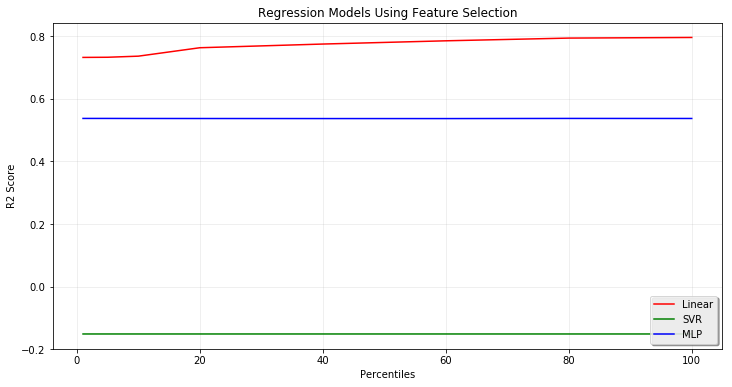

In [84]:
regr.do_plots()

# Vote Regression

In [85]:
# Vote ML

df_vote_X_mtx = df_vote_X.as_matrix()
df_vote_Y_arr = df_vote_Y['vote_average'].values * 10

regr = RegressionSteps(df_vote_X_mtx, df_vote_Y_arr,
                       percentiles = [1,5,10,20,40,60,80,100],
                       C_param=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                       layer_param=[(200), (300), (100,100), (300,100)],
                       do_std=False
                      )
regr.start()

Starting data split: 80/20

Percentile: 1
	Linear Regression:
	R2 score: 0.22

	Support Vector Regression:
	R2 score: 0.92

	Multi-layer Perceptron Regressor:
	R2 score: -1009992.29

Percentile: 5
	Linear Regression:
	R2 score: 0.26

	Support Vector Regression:
	R2 score: 0.94

	Multi-layer Perceptron Regressor:
	R2 score: -1863832.12

Percentile: 10
	Linear Regression:
	R2 score: 0.28

	Support Vector Regression:
	R2 score: 0.96

	Multi-layer Perceptron Regressor:
	R2 score: -1194563.10

Percentile: 20
	Linear Regression:
	R2 score: 0.31

	Support Vector Regression:
	R2 score: 0.97

	Multi-layer Perceptron Regressor:
	R2 score: -10576256.86

Percentile: 40
	Linear Regression:
	R2 score: 0.35

	Support Vector Regression:
	R2 score: 0.98

	Multi-layer Perceptron Regressor:
	R2 score: -1412455.10

Percentile: 60
	Linear Regression:
	R2 score: 0.37

	Support Vector Regression:
	R2 score: 0.99

	Multi-layer Perceptron Regressor:
	R2 score: -4823412.43

Percentile: 80
	Linear Regression:
	R

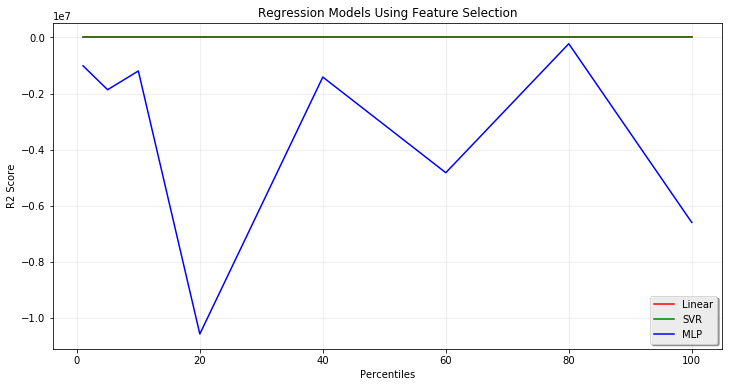

In [86]:
regr.do_plots()